In [1]:
import numpy as np
import pulp
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display,HTML,Image
import itertools
from z3 import *

### Puzzle as published 
https://www.janestreet.com/puzzles/block-party-2-index/

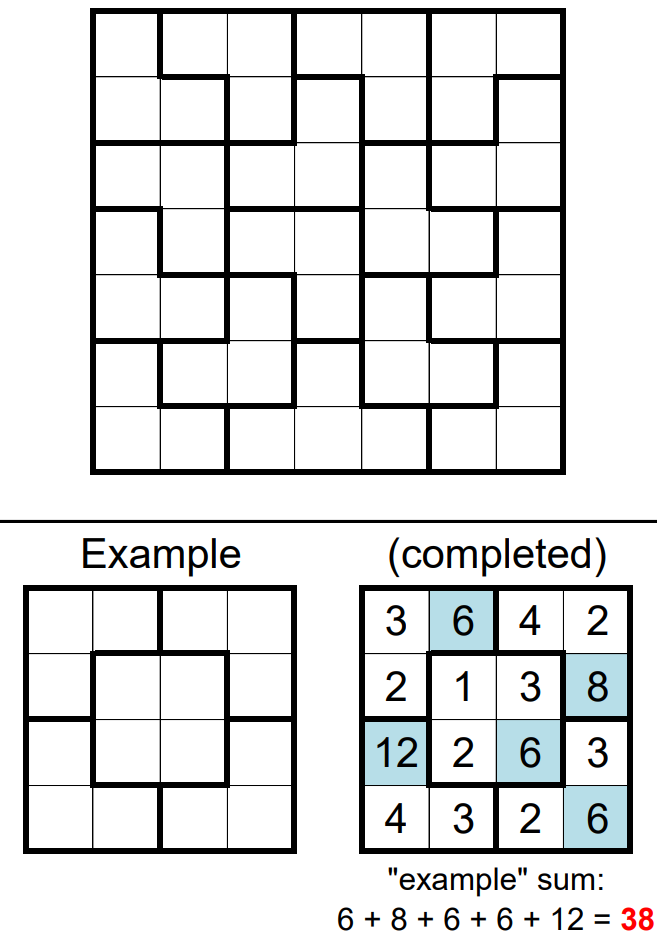

In [2]:
url='https://www.janestreet.com/puzzles/block-party-2-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Puzzle as published \n'+url))
display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1])))
display(Image('https://www.janestreet.com/puzzles/20181203_block_party_2.png',width=300))


In [3]:
# First thoughts
# 1 cannot be in any of the 3 hooks, so must be in the 4
# reduce the problem to fitting the 3 hooks by
# set one of the cells in the 4 hook to one and solve from there (set it as hook 16)

groups=np.array([[ 0,  1,  1,  2,  2,  3,  3],
                 [ 0,  0,  1,  4,  2,  3,  5],
                 [ 6,  6,  4,  4,  7,  5,  5],
                 [ 8,  6,  9,  9,  7,  7, 10],
                 [ 8,  8, 11,  9, 12, 10, 10],
                 [13, 11, 11, 15, 12, 12, 14],
                 [13, 13, 15, 15, 15, 14, 14]],dtype=int)

fixed =np.zeros((7,7),dtype=int)
fixed[groups==16] = 1

# from the published solution
solution = np.array([[ 6,  4, 20,  3, 12,  2,  5],
                     [ 2, 12,  5,  8,  4, 10,  3],
                     [12,  6,  2,  4,  3,  5, 15],
                     [ 3,  2,  6, 12,  5, 15,  4],
                     [ 5, 15,  4,  2,  8,  3, 12],
                     [20,  3, 12,  5,  2,  4,  6],
                     [ 4,  5,  3, 15,  1, 12,  2]
                    ],dtype =int)

def grid_print(groups,numbers):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    x = np.array((numbers).astype('int').astype('str'))
    x[x=="0"] ="-"
    ax1 = sns.heatmap(groups,annot=x,cbar=False,cmap="tab20",fmt="",linewidths=2,ax=ax[0])
    ax1.axis("off")
    ax2 =sns.heatmap(np.isin(numbers, [8,10,12,15,20]),annot=x,cbar=False,cmap="Greys",
                     fmt="",linewidths=2,ax=ax[1],linecolor ='grey',center =2)
    ax2.axis("off")
    plt.tight_layout()
    plt.show()
    
def neighbours(i,j,N):
    neigh = [(0,-1),(0,1),(1,0),(-1,0)]
    between = lambda x: x>=0 and x<N
    return [(i+x,j+y) for x,y in neigh if between(i+x)and between(j+y)]

In [4]:
# 49 cells - 16 totals - the cell with 1 = 32 to fill
# so 7 x (2,3,4,5) + 6 x 4
# how do we arrange those to give the lowest total with all the constraints
# solve that and output as possible cells

combinations = {(x,y):x*y for x,y  in itertools.combinations([2,3,4,5,6],2)}

prob = pulp.LpProblem("GetTiles",pulp.LpMinimize)
x = pulp.LpVariable.dicts("Combination",combinations.keys(),lowBound=0,upBound=7, cat='Integer') 

# objective
prob += pulp.lpSum([combinations[key]*x[key] for key in combinations])

# constraint 16 hoooks
prob += pulp.lpSum([x[key] for key in combinations]) == 16

# constraints for the numbers - can't have more than 7 of any one
totals = [7,7,7,7,4]
numbs =  [2,3,4,5,6]
for i in range(len(totals)):
    prob += pulp.lpSum([(numbs[i]  in key)*x[key] for key in combinations]) == totals[i]
    
# constraints for the totals - can't have more than 7 of any total (need to work out a nicer way of doing this)
    prob += pulp.lpSum([(combinations[key] ==12)*x[key] for key in combinations]) <= 7
    
prob.solve()
print("Total is: ",np.sum([combinations[key]*x[key].varValue for key in combinations]))

print("The hooks to use are :")
result_dict ={key:x[key].varValue for key in combinations}
display(result_dict)

possible_cells = []

for (a,b) in result_dict:
    count = result_dict[(a,b)]
    #for i in range(int(count)):
    if count > 0:
        possible_cells.append([a,b,a*b])

Total is:  210.0
The hooks to use are :


{(2, 3): 0.0,
 (2, 4): 2.0,
 (2, 5): 1.0,
 (2, 6): 4.0,
 (3, 4): 3.0,
 (3, 5): 4.0,
 (3, 6): 0.0,
 (4, 5): 2.0,
 (4, 6): 0.0,
 (5, 6): 0.0}

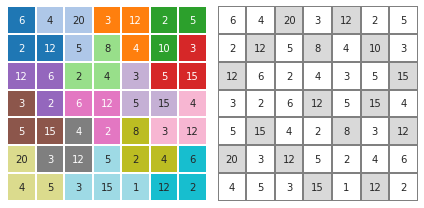

Result 210 after 18.007 seconds


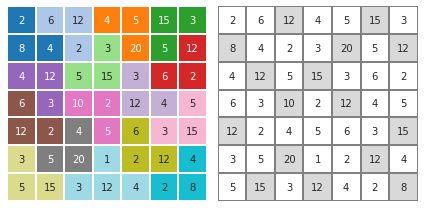

Result 210 after 53.728 seconds
Failed


In [10]:
N = 7
start = time.time()
#grids
X = np.array(IntVector("x",N*N),dtype=object).reshape((N,N))
Y = np.array(IntVector("y",N*N),dtype=object).reshape((N,N))
s = Tactic('qffd').solver()

s += [And(e>=1,e<=20) for (i,j),e in np.ndenumerate(X)]

s += [And(y>=0,y<=1) for _,y in np.ndenumerate(Y)]

s += [If(Y[i,j]==0,
         Or([x==i for i in [1,2,3,4,5,6]]),
         Or([x==i for i in [6,8,10,12,15,20]]))
     for (i,j),x in np.ndenumerate(X)]

# constraints
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if i==n]) for n in range(N)]
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if j==n]) for n in range(N)]
s += [Distinct([e for (i,j),e in np.ndenumerate(X) if groups[i,j]==n]) for n in range(16)]

s += [PbEq([(e==1,1) for (i,j),e in np.ndenumerate(Y) if groups[i,j]==n],1) for n in range(16)]
s += [Implies(e==1,And([Y[k,l]!=1 for k,l in neighbours(i,j,N)])) for (i,j),e in np.ndenumerate(Y)]

s +=  [Product([If(Y[i,j] == 0,e,1) for (i,j),e in np.ndenumerate(X) if groups[i,j]==n]) ==
      Sum([If(Y[i,j] == 1,e,0) for (i,j),e in np.ndenumerate(X) if groups[i,j]==n])
      for n in range(16)]

s += Sum([If(Y[i,j] == 1,e,0) for (i,j),e in np.ndenumerate(X)]) ==210

while s.check() == sat:
    m = s.model()
    evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
    r = evalu(X)
    t = evalu(Y)
    grid_print(groups,r)
    print("Result {} after {:.3f} seconds".format(np.sum(r[t==1]),time.time()-start))
    s += Or([X[i,j] != int(e) for (i,j),e in np.ndenumerate(r)])
else:
    print("Failed")

In [ ]:
url='https://www.janestreet.com/puzzles/block-party-2-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
display(Markdown('### Solution as published \n'+url))
display(HTML(str(soup.find_all('div', {'class' :'inner-wrapper'})[1])))
display(Image('https://www.janestreet.com/puzzles/20181228_block_party_2_ans.png',width=300))